# 第5章: 係り受け解析
夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

In [0]:
!wget https://nlp100.github.io/data/neko.txt

In [0]:
!apt install mecab libmecab-dev mecab-ipadic-utf8

In [0]:
FILE_ID = "0B4y35FiV1wh7QVR6VXJ5dWExSTQ"
FILE_NAME = "crfpp.tar.gz"
!wget 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O $FILE_NAME
!tar xvf crfpp.tar.gz
%cd CRF++-0.58
!./configure && make && make install && ldconfig
%cd ..

In [0]:
FILE_ID = "0B4y35FiV1wh7SDd1Q1dUQkZQaUU"
FILE_NAME = "cabocha-0.69.tar.bz2"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt
!tar -xvf cabocha-0.69.tar.bz2
%cd cabocha-0.69
!./configure -with-charset=utf-8 && make && make check && make install && ldconfig
%cd ..

In [0]:
!cabocha -f1 -o neko.txt.cabocha neko.txt

In [35]:
!wc -l ./neko.txt.cabocha

297283 ./neko.txt.cabocha


In [36]:
!head -15 ./neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS


## 40. 係り受け解析結果の読み込み（形態素）
***
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [0]:
class Morph:
  def __init__(self, morph):
    (surface, attr) = morph.split('\t')
    attr = attr.split(',')
    self.surface = surface
    self.base = attr[6]
    self.pos = attr[0]
    self.pos1 = attr[1]

In [38]:
filename = './neko.txt.cabocha'

# 文単位に分割して読込
with open(filename, mode='r', encoding='utf-8') as f:
  text = f.read().split('EOS\n')

# 確認
print(text[2])

# 指定フォーマットに整形
sentences = []
for sentence in text:
  morphs = []
  for line in sentence.split('\n'):
    if line == '' or line[0] == '*':  # 文末または係り受け関係を表す行 --> スキップ
      continue
    else:  # 形態素を表す行 --> Morphを適用しリストに追加
      morphs.append(Morph(line))
  sentences.append(morphs)

# 確認
for m in sentences[2]:
  print(vars(m))

* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。

{'surface': '\u3000', 'base': '\u3000', 'pos': '記号', 'pos1': '空白'}
{'surface': '吾輩', 'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞'}
{'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}
{'surface': '猫', 'base': '猫', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'で', 'base': 'だ', 'pos': '助動詞', 'pos1': '*'}
{'surface': 'ある', 'base': 'ある', 'pos': '助動詞', 'pos1': '*'}
{'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}


## 41. 係り受け解析結果の読み込み（文節・係り受け）
***
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [0]:
class Chunk():
  def __init__(self, morphs, dst):
    self.morphs = morphs
    self.dst = dst
    self.srcs = []


class Sentence():
  def __init__(self, chunks):
    self.chunks = chunks
    for i, chunk in enumerate(self.chunks):
      if chunk.dst != -1:
        self.chunks[chunk.dst].srcs.append(i)

In [40]:
filename = './neko.txt.cabocha'

# 文単位に分割して読込
with open(filename, mode='r', encoding='utf-8') as f:
  text = f.read().split('EOS\n')

# 確認
for t in text[7].split('\n'):
  print(t)

# 指定フォーマットに整形
sentences = []
for sentence in text:
  if sentence == '':  # 空の文 --> 以下の処理を省略して空のSentenceオブジェクトをsentencesリストに追加
    sentences.append(Sentence([]))
  else:
    chunks = []
    morphs = []
    dst = None
    for line in sentence.split('\n'):
      if line == '':  # 文末を表す行 --> 文末直前の文節の情報にChunkを適用しchunksリストに追加
        chunks.append(Chunk(morphs, dst))
      elif line[0] == '*':  # 係り受け関係を表す行 --> 直前の文節の情報にChunkを適用しchunksリストに追加 + 直後の文節の係り先を取得
        if len(morphs) > 0:
          chunks.append(Chunk(morphs, dst))
          morphs = []
        dst = int(line.split(' ')[2].rstrip('D'))
      else:  # 形態素を表す行 --> Morphを適用しmorphsリストに追加
        morphs.append(Morph(line))
    sentences.append(Sentence(chunks))  # Sentenceを適用しsentencesリストに追加

# 確認
for chunk in sentences[7].chunks:
  print([morph.surface for morph in chunk.morphs], chunk.dst, chunk.srcs)

* 0 5D 0/1 -1.514009
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/1 1.311423
ここ	名詞,代名詞,一般,*,*,*,ここ,ココ,ココ
で	助詞,格助詞,一般,*,*,*,で,デ,デ
* 2 3D 0/1 0.123057
始め	動詞,自立,*,*,一段,連用形,始める,ハジメ,ハジメ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
* 3 4D 0/1 1.440044
人間	名詞,一般,*,*,*,*,人間,ニンゲン,ニンゲン
という	助詞,格助詞,連語,*,*,*,という,トイウ,トユウ
* 4 5D 0/1 -1.514009
もの	名詞,非自立,一般,*,*,*,もの,モノ,モノ
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
* 5 -1D 0/1 0.000000
見	動詞,自立,*,*,一段,連用形,見る,ミ,ミ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
。	記号,句点,*,*,*,*,。,。,。

['吾輩', 'は'] 5 []
['ここ', 'で'] 2 []
['始め', 'て'] 3 [1]
['人間', 'という'] 4 [2]
['もの', 'を'] 5 [3]
['見', 'た', '。'] -1 [0, 4]


## 42. 係り元と係り先の文節の表示
***
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [41]:
sentence = sentences[7]
for chunk in sentence.chunks:
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs])
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs])
    print(modifier, modifiee, sep='\t')

吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
***
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [42]:
sentence = sentences[7]
for chunk in sentence.chunks:
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs])
    modifier_pos = [morph.pos for morph in chunk.morphs]
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs])
    modifiee_pos = [morph.pos for morph in sentence.chunks[int(chunk.dst)].morphs]
    if '名詞' in modifier_pos and '動詞' in modifiee_pos:
      print(modifier, modifiee, sep='\t')

吾輩は	見た
ここで	始めて
ものを	見た


## 44. 係り受け木の可視化
***
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

In [43]:
# 日本語表示用フォントのインストール
!apt install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


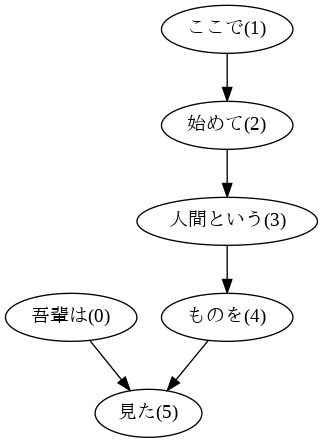

In [44]:
import pydot
from IPython.display import Image,display_png
from graphviz import Digraph
 
sentence = sentences[7]
edges = []
for id, chunk in enumerate(sentence.chunks):
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs] + ['(' + str(id) + ')'])
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs] + ['(' + str(chunk.dst) + ')'])
    edges.append([modifier, modifiee])
n = pydot.Node('node')
n.fontname = 'IPAGothic'
g = pydot.graph_from_edges(edges, directed=True)
g.add_node(n)
g.write_png('./ans44.png')
display_png(Image('./ans44.png'))

## 45. 動詞の格パターンの抽出
***
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる  


このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [0]:
with open('./ans45.txt', 'w') as f:
  for sentence in sentences:
    for chunk in sentence.chunks:
      for morph in chunk.morphs:
        if morph.pos == '動詞':  # chunkの左から順番に動詞を探す
          cases = []
          for src in chunk.srcs:  # 見つけた動詞の係り元chunkから助詞を探す
            cases = cases + [morph.surface for morph in sentence.chunks[src].morphs if morph.pos == '助詞']
          if len(cases) > 0:  # 助詞が見つかった場合は重複除去後辞書順にソートして出力
            cases = sorted(list(set(cases)))
            line = '{}\t{}'.format(morph.base, ' '.join(cases))
            print(line, file=f)
          break

In [46]:
# 確認
!cat ./ans45.txt | sort | uniq -c | sort -nr | head -n 10

   2485 ある	が
   1438 つく	か が
    680 云う	に
    591 する	が で と
    344 見る	の
    340 つかむ	を
    275 云う	と は
    270 思う	と
    248 かかる	が て
    245 かく	たり を


In [47]:
!cat ./ans45.txt | grep 'する' | sort | uniq -c | sort -nr | head -n 5

   1151 する	が
    751 する	が と
    308 する	が で と
    130 する	でも に
    109 する	て に は を


In [48]:
!cat ./ans45.txt | grep '見る' | sort | uniq -c | sort -nr | head -n 5

    344 見る	の
    107 見る	は を
     35 見る	が に を
     27 見る	から て
     22 見る	から


In [49]:
!cat ./ans45.txt | grep '与える' | sort | uniq -c | sort -nr | head -n 5

      5 与える	ば を
      3 与える	て に は を
      3 与える	け に を
      2 与える	だけ で に を
      1 与える	に に対して のみ は も


## 46. 動詞の格フレーム情報の抽出
***
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

In [0]:
with open('./ans46.txt', 'w') as f:
  for sentence in sentences:
    for chunk in sentence.chunks:
      for morph in chunk.morphs:
        if morph.pos == '動詞':  # chunkの左から順番に動詞を探す
          cases = []
          modi_chunks = []
          for src in chunk.srcs:  # 見つけた動詞の係り元chunkから助詞を探す
            case = [morph.surface for morph in sentence.chunks[src].morphs if morph.pos == '助詞']
            if len(case) > 0:  # 助詞を含むchunkの場合は助詞と項を取得
              cases = cases + case
              modi_chunks.append(''.join(morph.surface for morph in sentence.chunks[src].morphs if morph.pos != '記号'))
          if len(cases) > 0:  # 助詞が1つ以上見つかった場合は重複除去後辞書順にソートし、項と合わせて出力
            cases = sorted(list(set(cases)))
            line = '{}\t{}\t{}'.format(morph.base, ' '.join(cases), ' '.join(modi_chunks))
            print(line, file=f)
          break

In [51]:
# 確認
!cat ./ans46.txt | head -n 10

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	だけ て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て


## 47. 機能動詞構文のマイニング
***
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [0]:
with open('./ans47.txt', 'w') as f:
  for sentence in sentences:
    for chunk in sentence.chunks:
      for morph in chunk.morphs:
        if morph.pos == '動詞':  # chunkの左から順番に動詞を探す
          for i, src in enumerate(chunk.srcs):  # 見つけた動詞の係り元chunkが「サ変接続名詞+を」で構成されるか確認
            if len(sentence.chunks[src].morphs) == 2 and sentence.chunks[src].morphs[0].pos1 == 'サ変接続' and sentence.chunks[src].morphs[1].surface == 'を':
              predicate = ''.join([sentence.chunks[src].morphs[0].surface, sentence.chunks[src].morphs[1].surface, morph.base])
              cases = []
              modi_chunks = []
              for src_r in chunk.srcs[:i] + chunk.srcs[i + 1:]:  # 残りの係り元chunkから助詞を探す
                case = [morph.surface for morph in sentence.chunks[src_r].morphs if morph.pos == '助詞']
                if len(case) > 0:  # 助詞を含むchunkの場合は助詞と項を取得
                  cases = cases + case
                  modi_chunks.append(''.join(morph.surface for morph in sentence.chunks[src_r].morphs if morph.pos != '記号'))
              if len(cases) > 0:  # 助詞が1つ以上見つかった場合は重複除去後辞書順にソートし、項と合わせて出力
                cases = sorted(list(set(cases)))
                line = '{}\t{}\t{}'.format(predicate, ' '.join(cases), ' '.join(modi_chunks))
                print(line, file=f)
              break

In [53]:
# 確認
!cat ./ans47.txt | cut -f 1 | sort | uniq -c | sort -nr | head -n 10

     29 返事をする
     21 挨拶をする
     18 話をする
      9 質問をする
      8 昼寝をする
      8 喧嘩をする
      7 真似をする
      7 問答をやる
      6 相談をする
      5 質問をかける


In [54]:
!cat ./ans47.txt | cut -f 1,2 | sort | uniq -c | sort -nr | head -n 10

      9 返事をする	と よ
      8 返事をする	て
      6 話をする	か は
      6 話をする	に
      6 挨拶をする	で
      5 昼寝をする	が
      5 挨拶をする	から
      5 挨拶をする	か と も
      5 喧嘩をする	で
      4 返事をする	から と


## 48. 名詞から根へのパスの抽出
***
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する

In [55]:
sentence = sentences[7]
for chunk in sentence.chunks:
  if '名詞' in [morph.pos for morph in chunk.morphs]:  # chunkが名詞を含むか確認
    path = [''.join(morph.surface for morph in chunk.morphs if morph.pos != '記号')]
    while chunk.dst != -1:  # 名詞を含むchunkを先頭に、dstを根まで順に辿ってリストに追加
      path.append(''.join(morph.surface for morph in sentence.chunks[chunk.dst].morphs if morph.pos != '記号'))
      chunk = sentence.chunks[chunk.dst]
    print(' -> '.join(path))

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


## 49. 名詞間の係り受けパスの抽出
***
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示

In [56]:
from itertools import combinations

sentence = sentences[7]
nouns = []
for i, chunk in enumerate(sentence.chunks):
  if '名詞' in [morph.pos for morph in chunk.morphs]:  # 名詞を含む文節を抽出
    nouns.append(i)
for i, j in combinations(nouns, 2):  # 名詞を含む文節のペアごとにパスを作成
  path_i = []
  path_j = []
  while i != j:
    if i < j:
      path_i.append(i)
      i = sentence.chunks[i].dst
    else:
      path_j.append(j)
      j = sentence.chunks[j].dst
  if len(path_j) == 0:  # 1つ目のケース
    chunk_X = ''.join([morph.surface if morph.pos != '名詞' else 'X' for morph in sentence.chunks[path_i[0]].morphs])
    chunk_Y = ''.join([morph.surface if morph.pos != '名詞' else 'Y' for morph in sentence.chunks[i].morphs])
    path_XtoY = [chunk_X] + [''.join(morph.surface for morph in sentence.chunks[n].morphs) for n in path_i[1:]] + [chunk_Y]
    print(' -> '.join(path_XtoY))
  else:  # 2つ目のケース
    chunk_X = ''.join([morph.surface if morph.pos != '名詞' else 'X' for morph in sentence.chunks[path_i[0]].morphs])
    chunk_Y = ''.join([morph.surface if morph.pos != '名詞' else 'Y' for morph in sentence.chunks[path_j[0]].morphs])
    chunk_k = ''.join([morph.surface for morph in sentence.chunks[i].morphs])
    path_X = [chunk_X] + [''.join(morph.surface for morph in sentence.chunks[n].morphs) for n in path_i[1:]]
    path_Y = [chunk_Y] + [''.join(morph.surface for morph in sentence.chunks[n].morphs) for n in path_j[1:]]
    print(' | '.join([' -> '.join(path_X), ' -> '.join(path_Y), chunk_k]))

Xは | Yで -> 始めて -> 人間という -> ものを | 見た。
Xは | Yという -> ものを | 見た。
Xは | Yを | 見た。
Xで -> 始めて -> Yという
Xで -> 始めて -> 人間という -> Yを
Xという -> Yを
